#Estimación de probabilidad de llenar vacantes de IES

##0. Instalación y carga de librerías

In [ ]:
!pip install catboost --quiet

     |████████████████████████████████| 67.3MB 52kB/s 


In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.ensemble import GradientBoostingClassifier
import catboost as cb
import xgboost as xgb
import lightgbm as lgb

from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay,classification_report
from sklearn.model_selection import GridSearchCV
import multiprocessing

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

#import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

##1. Carga y formateo de archivo base

In [ ]:
files = files.upload()

Saving Consolidado_final_v2.xlsx to Consolidado_final_v2.xlsx


In [ ]:
archivo = pd.read_excel('Consolidado_final_v2.xlsx')
archivo.head(3)

,Año,codigo,NOMBRE IES,NOMBRE CARRERA,TIPO INST 2,TIPO INST 3,REGION SEDE,COMUNA SEDE,AREA CARRERA GENERICA,AREA CONOCIMIENTO,n_24,n_25,n_26,n_Total,m_24,m_25,vacantes_1S,demanda_1,sobrecupos,Convocados,demanda_2,Muestra_2021,auxiliar_muestra,llena_vacante,llena_vacante2,Deficit,gratuidad,duracion,arancel_2021,arancel_anual,matricula_2021,PCT_NOTAS,PCT_RANKING,PCT_LENG,PCT_MATE,PCT_COLEGIO,RM,V,VIII,ingreso_1,ingreso_2,ingreso_3,ingreso_4,ingreso_5,emplea_1,emplea_2,acreditacion
0,2019,11001,UNIVERSIDAD DE CHILE,ARQUITECTURA,Universidades CRUCH,Universidades Estatales CRUCH,REGION METROPOLITANA,SANTIAGO,Arquitectura,Arte y Arquitectura,311,277,451,1039,647.6,600.0,280,3.710714,30.0,310.0,3.351613,NO,NO,SI,1,0,1,12.0,4472200.0,4174900.0,149000.0,20,20,20,30,40,1,0,0,795871.710423,941552.758398,1.071521e+06,1.221897e+06,1.321313e+06,0.741593,0.817106,7
1,2019,11003,UNIVERSIDAD DE CHILE,ACTUACION TEATRAL,Universidades CRUCH,Universidades Estatales CRUCH,REGION METROPOLITANA,SANTIAGO,Actuación y Teatro,Arte y Arquitectura,23,21,15,59,687.9,612.8,23,2.565217,0.0,23.0,2.565217,NO,NO,SI,1,0,1,10.0,3756700.0,3273900.0,149000.0,10,20,30,15,30,1,0,0,576797.728865,626869.675583,7.334167e+05,8.081382e+05,8.758894e+05,0.273481,0.348315,7
2,2019,11004,UNIVERSIDAD DE CHILE,DISEÑO TEATRAL,Universidades CRUCH,Universidades Estatales CRUCH,REGION METROPOLITANA,SANTIAGO,Diseño Teatral,Arte y Arquitectura,28,7,33,68,606.5,600.2,23,2.956522,5.0,28.0,2.428571,NO,NO,SI,1,0,1,10.0,3756700.0,3273900.0,149000.0,10,20,25,20,30,1,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


El año y el área de conocimiento las asigno como variables categóricas. El año tiene mejor rendimiento en el modelo como variable categórica que como numérica.

In [ ]:
archivo['Año'] = archivo['Año'].astype('category')
archivo['AREA CONOCIMIENTO'] = archivo['AREA CONOCIMIENTO'].astype('category')

Estructura del archivo en donde se aprecia que hay valores nulos que deben trabajarse. La idea es tener disponibles las 4200 observaciones para las variables que se van a elegir como predictoras en el modelo.

In [ ]:
archivo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542 entries, 0 to 5541
Data columns (total 47 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   Año                    5542 non-null   category
 1   codigo                 5542 non-null   int64   
 2   NOMBRE IES             5542 non-null   object  
 3   NOMBRE CARRERA         5542 non-null   object  
 4   TIPO INST 2            5542 non-null   object  
 5   TIPO INST 3            5542 non-null   object  
 6   REGION SEDE            5542 non-null   object  
 7   COMUNA SEDE            5542 non-null   object  
 8   AREA CARRERA GENERICA  5542 non-null   object  
 9   AREA CONOCIMIENTO      5542 non-null   category
 10  n_24                   5542 non-null   int64   
 11  n_25                   5542 non-null   int64   
 12  n_26                   5542 non-null   int64   
 13  n_Total                5542 non-null   int64   
 14  m_24                   5537 non-null   f

##2. Elección de variables y construcción de Dataframes de entrenamiento y prueba

Las variables a utilizar para predecir si se llena una vacante serán:

- Año: Año del proceso.
- AREA CONOCIMIENTO: Área de conocimiento de la carrera según Mineduc.
- acreditacion: Años de acreditación de la universidad.
- gratuidad: Si la carrera tuvo gratuidad en el año.
- duracion: duración en semestres de la carrera.
- PCT_COLEGIO: Suma de las ponderaciones de NEM y ranking de notas que exige la carrera.
- matricula_2021: Valor de la matrícula 2021 de la carrera (info SIES).
- RM: Si la carrera es de la región metropolitana.
- V: Si la carrera es de la región V.
- VIII: Si la carrera es de la región VIII.
- ingreso_3: Ingreso bruto al tercer año de la carrera (info SIES).
- emplea_1: Tasa de empleabilidad al primer año de la carrera (info SIES).

Se optó por la matricula en vez del arancel, pues la matrícula tiene mejor rendimiento en el modelo. Lo mismo con el ingreso al tercer año (se probó el ingreso desde el primer al quinto año).
Por otro lado, no aporta (en ciertos casos empeora) a mejorar el rendimiento del modelo agregar al nombre de la institución superior.

In [ ]:
features = ['Año','AREA CONOCIMIENTO','acreditacion','gratuidad','duracion','PCT_COLEGIO','matricula_2021','RM','V','VIII','ingreso_3','emplea_1']

Las variables duración, matricula_2021, ingreso_3 y emplea_1 tienen valores nulos y deben estimarse. Se utilizará un algoritmo iterativo para imputar los valores nulos siguiendo los patrones de las demás variables numéricas.
Esto es mejor que borrar las observaciones que tienen valores nulos, ya que se pierde información y empeora el rendimiento del modelo.

In [ ]:
numeric = archivo[features].select_dtypes(include=['float64','int64','int32']).columns.to_list()

imputer = IterativeImputer()
data = imputer.fit_transform(archivo[numeric])
nuevo_data = pd.DataFrame(data, columns=numeric)

archivo['duracion'] = nuevo_data['duracion']
archivo['matricula_2021'] = nuevo_data['matricula_2021']
archivo['ingreso_3'] = nuevo_data['ingreso_3']
archivo['emplea_1'] = nuevo_data['emplea_1']

El archivo con las variables elegidas ahora no tiene valores nulos:

In [ ]:
archivo[features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5542 entries, 0 to 5541
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Año                5542 non-null   category
 1   AREA CONOCIMIENTO  5542 non-null   category
 2   acreditacion       5542 non-null   int64   
 3   gratuidad          5542 non-null   int64   
 4   duracion           5542 non-null   float64 
 5   PCT_COLEGIO        5542 non-null   int64   
 6   matricula_2021     5542 non-null   float64 
 7   RM                 5542 non-null   int64   
 8   V                  5542 non-null   int64   
 9   VIII               5542 non-null   int64   
 10  ingreso_3          5542 non-null   float64 
 11  emplea_1           5542 non-null   float64 
dtypes: category(2), float64(4), int64(6)
memory usage: 444.4 KB


La matriz de variables explicativas será X y la variable target Y será llena_vacante2 que indica si la carrera llena o no la vacante del año.

In [ ]:
X = archivo[features]
y = archivo['llena_vacante2']

Se separa el archivo en dos: uno para entrenar el modelo y en otra para probarlo. La muestra de prueba será del 12% de la muestra total y con ello se tendrán 4876 observaciones para entrenar el modelo y 666 para probarlo. Esas 666 observaciones quedan aisladas.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.12,random_state=42) #stratify=y

In [ ]:
X_train.shape, X_test.shape

((4876, 12), (666, 12))

In [ ]:
X_test.groupby('Año').size()

Año
2019    231
2020    213
2021    222
dtype: int64

Como se van a probar varios algoritmos y cada cual tiene requerimientos particulares, para que los datos sean aceptados, se estandarizarán las variables numéricas y las categóricas se transformarán como One Hot Encoder (cada categoría va a ser una variable que vale 1 o 0).

In [ ]:
# Se identifica el nombre de las columnas numéricas y categóricas
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()
numeric_cols = X_train.select_dtypes(include=['float64', 'int64','int32']).columns.to_list()

# Se aplica one-hot-encoding solo a las columnas categóricas, se estandarizan las numéricas.
preprocessor = ColumnTransformer(
                    [('scale', StandardScaler(), numeric_cols),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'), cat_cols)],
                    remainder='passthrough')

X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

# Convertir el output del ColumnTransformer en dataframe y añadir el nombre de las columnas
# Nombre de todas las columnas
encoded_cat = preprocessor.named_transformers_['onehot'].get_feature_names(cat_cols)
labels = np.concatenate([encoded_cat,numeric_cols])

# Conversión a dataframe
X_train_prep = pd.DataFrame(X_train_prep, columns=labels) #pd.DataFrame.sparse.from_spmatrix
X_test_prep  = pd.DataFrame(X_test_prep, columns=labels)
X_train_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4876 entries, 0 to 4875
Data columns (total 23 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Año_2019                                     4876 non-null   float64
 1   Año_2020                                     4876 non-null   float64
 2   Año_2021                                     4876 non-null   float64
 3   AREA CONOCIMIENTO_Administración y Comercio  4876 non-null   float64
 4   AREA CONOCIMIENTO_Agropecuaria               4876 non-null   float64
 5   AREA CONOCIMIENTO_Arte y Arquitectura        4876 non-null   float64
 6   AREA CONOCIMIENTO_Ciencias Básicas           4876 non-null   float64
 7   AREA CONOCIMIENTO_Ciencias Sociales          4876 non-null   float64
 8   AREA CONOCIMIENTO_Derecho                    4876 non-null   float64
 9   AREA CONOCIMIENTO_Educación                  4876 non-null   float64
 10  

##3. Entrenamiento de modelos

Ya teniendo definidos los archivos de entrenamiento y prueba con el formato adecuado, se entrenarán 12 modelos para ver su rendimiento a la hora de predecir la variable target de llenar vacantes. Luego del entrenamiento, se observa que los 5 mejores modelos son aquellos basados en la técnica del boosting, en donde el algoritmo a partir de varios modelos va aprendiendo de forma secuencial de los errores de cada modelo precedente para ir mejorando el pronóstico final.
En particular, el que tiene mejor rendimiento en score es Catboost con un 81,49% de accuracy para el set de prueba, logrando un buen balance de rendimiento con el set de entrenamiento (lo cual es importante para poder generalizar el modelo).

(Catboost es un algoritmo ensamblado de machine learning de la empresa de tecnología más grande de Rusia: Yandex. El algoritmo fue liberado hace unos 3 años, y suele encabezar las competencias de machine learning junto con las redes neuronales).

In [ ]:
score_train =[]
score_test = []

names = ['CatBoost', 'XGBoost','LightGBM','Logistic Regression', 'Decision Tree', 'Random Forest', 'Support Vector Machine',
         'AdaBoost', 'Gradient Boosting', 'K Neighbors', 'Extra Trees','Neural Network']

models = [cb.CatBoostClassifier(silent=True), xgb.XGBClassifier(),lgb.LGBMClassifier(),LogisticRegression(), DecisionTreeClassifier(),
          RandomForestClassifier(), SVC(), AdaBoostClassifier(), GradientBoostingClassifier(), KNeighborsClassifier(), ExtraTreesClassifier(), MLPClassifier()]


for model in zip(names, models):
  model[1].fit(X_train_prep, y_train)
  score_train.append(model[1].score(X_train_prep,y_train))
  score_test.append(model[1].score(X_test_prep,y_test))

pd.DataFrame({'Modelo':names,
              'Score Train':score_train,
              'Score_Test': score_test}).sort_values('Score_Test', ascending=False)

,Modelo,Score Train,Score_Test
0,CatBoost,0.884126,0.839339
2,LightGBM,0.895406,0.834835
1,XGBoost,0.807424,0.813814
5,Random Forest,0.974774,0.806306
8,Gradient Boosting,0.808655,0.804805
6,Support Vector Machine,0.797580,0.789790
10,Extra Trees,0.974774,0.786787
11,Neural Network,0.840238,0.782282
7,AdaBoost,0.764561,0.777778
9,K Neighbors,0.835931,0.777778


##4. Validación de modelo elegido

**(Paréntesis: salida de los coeficientes de la Regresión Logística)**

In [ ]:
model_2 = LogisticRegression()
model_2.fit(X_train_prep,y_train)

print("Intercepto:", model_2.intercept_)
print('Exp Intercepto', np.exp(model_2.intercept_))

pd.DataFrame({'Variable':X_train_prep.columns,
              'Coeficiente':model_2.coef_.flatten(),
              'Exp Coeficiente': np.exp(model_2.coef_.flatten())})

Intercepto: [1.05546226]
Exp Intercepto [2.87330307]


,Variable,Coeficiente,Exp Coeficiente
0,Año_2019,0.339743,1.404586
1,Año_2020,0.613656,1.847173
2,Año_2021,0.205815,1.228526
3,AREA CONOCIMIENTO_Administración y Comercio,-0.130486,0.877669
4,AREA CONOCIMIENTO_Agropecuaria,0.271114,1.311425
5,AREA CONOCIMIENTO_Arte y Arquitectura,-0.104296,0.900959
6,AREA CONOCIMIENTO_Ciencias Básicas,-0.131454,0.876820
7,AREA CONOCIMIENTO_Ciencias Sociales,0.125472,1.133683
8,AREA CONOCIMIENTO_Derecho,0.054171,1.055665
9,AREA CONOCIMIENTO_Educación,0.266042,1.304789


(---fin de paréntesis---)

En adelante se usará Catboost para evaluar el modelo y hacer las predicciones.

In [ ]:
model = cb.CatBoostClassifier(silent=True)
model.fit(X_train_prep,y_train)

model.score(X_test_prep,y_test)

0.8393393393393394

Si se revisa la importancia de cada variable en el modelo, se observa que el área de conocimiento, el año, el ingreso del tercer año y la empleabilidad son los más relevantes.

In [ ]:
importancia_predictores = pd.DataFrame(
                            {'predictor': X_train_prep.columns,
                             'importancia': model.feature_importances_}
                            )
importancia_predictores.sort_values('importancia', ascending=False)

,predictor,importancia
4,AREA CONOCIMIENTO_Agropecuaria,14.833501
8,AREA CONOCIMIENTO_Derecho,13.813920
9,AREA CONOCIMIENTO_Educación,12.098633
0,Año_2019,8.092306
21,ingreso_3,8.081873
2,Año_2021,6.854189
1,Año_2020,5.896648
22,emplea_1,5.605239
12,AREA CONOCIMIENTO_Tecnología,4.076724
10,AREA CONOCIMIENTO_Humanidades,3.791582


Si bien el accuracy global es del 83%, se pueden revisar otras métricas relevantes para evaluar el modelo, como la precisión y el recall en el pronóstico cuando la variable llena_vacante vale 1.

In [ ]:
predict = model.predict(X_test_prep)
print(classification_report(y_test,predict))

              precision    recall  f1-score   support

           0       0.75      0.73      0.74       211
           1       0.88      0.89      0.88       455

    accuracy                           0.84       666
   macro avg       0.82      0.81      0.81       666
weighted avg       0.84      0.84      0.84       666



En la matriz de confusión siguiente se pueden observar cómo se comporta el modelo con el set de prueba de 832 observaciones. Por ejemplo, de las 540 observaciones que tienen valor 1 en la realidad, el modelo acierta el 484, lo cual es un acierto del 90% (métrica llamada recall). Así también, de las 582 observaciones que el modelo predice como 1, en realidad son 484 las que son efectivamente 1, lo cual da una precisión de 83%. La mezcla de ambos indicadores es el f1-score, calculado en 86%, lo que es en general un buen indicador.

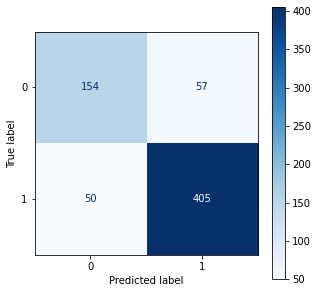

In [ ]:
confusion = confusion_matrix(y_test, predict)

fig, ax = plt.subplots(figsize=(5,5))
cm_display_CB = ConfusionMatrixDisplay(confusion,display_labels=[0,1])
cm_display_CB.plot(cmap='Blues', ax=ax, values_format='g');

In [ ]:
X_test['predict'] = predict
X_test['real'] = y_test

X_test['acierto'] = (predict== y_test)
X_test.head()

,Año,AREA CONOCIMIENTO,acreditacion,gratuidad,duracion,PCT_COLEGIO,matricula_2021,RM,V,VIII,ingreso_3,emplea_1,predict,real,acierto
4235,2021,Educación,5,1,10.0,50,155000.0,0,0,0,8.169302e+05,0.869565,0,0,True
4908,2021,Tecnología,5,0,8.0,40,370000.0,1,0,0,1.592718e+06,0.879213,0,0,True
3418,2020,Salud,4,1,10.0,20,240000.0,0,0,0,7.874125e+05,0.423695,1,1,True
230,2019,Tecnología,6,1,11.0,20,208000.0,0,1,0,1.813632e+06,0.871046,1,1,True
1315,2019,Ciencias Básicas,5,0,4.0,40,320000.0,0,0,1,1.169311e+06,0.731013,0,1,False


In [ ]:
X_test.groupby('Año').mean('acierto').loc[:,'acierto']

Año
2019    0.883117
2020    0.798122
2021    0.833333
Name: acierto, dtype: float64

##5. Aplicaciones

Como ejemplo de aplicación se buscará predecir la probabilidad de una carrera de Salud de 10 semestres (Enfermería) logre llenar las vacantes, utilizando otros parámetros aproximados.
En este caso hay un 89% de probabilidad de que se llenen las vacantes, por lo cual el modelo predice que se van a llenar vacantes (valor 1).

In [ ]:
prueba = pd.DataFrame({'Año': [2020],
                       'AREA CONOCIMIENTO':['Salud'],
                       'acreditacion':[4],
                       'gratuidad':[0], #sin gratuidad
                       'duracion':[10],
                       #'vacantes_1S':[60],
                       'PCT_COLEGIO':[50],
                       'matricula_2021':[170000],
                       'RM':[1],
                       'V':[0],
                       'VIII':[0],
                       'ingreso_3':[1255000],
                       'emplea_1':[0.665]})

X_prueba_prep  = preprocessor.transform(prueba)
model.predict_proba(X_prueba_prep)

array([[0.13461999, 0.86538001]])

In [ ]:
model.predict(X_prueba_prep)

array([1])

Haciendo lo mismo, pero con otra carrera más corta del área de salud de 5 semestres (TNS en Enfermería), con sus ingresos y empleabilidad esperada, el modelo predice que hay una probabilidad del 12% de que se llenen vacantes, por lo cual predice que no se van a llenar al ser la probabilidad menor al 50% (valor 0).

In [ ]:
prueba2 = pd.DataFrame({'Año': [2020],
                       'AREA CONOCIMIENTO':['Salud'],
                        'acreditacion':[4], #4 años de acreditacion
                       'gratuidad':[0], #sin gratuidad
                       'duracion':[5],
                       #'vacantes_1S':[60],
                       'PCT_COLEGIO':[50],
                       'matricula_2021':[170000],
                       'RM':[1],
                        'V':[0],
                        'VIII':[0],
                       'ingreso_3':[544000],
                       'emplea_1':[0.44]})

X_prueba2_prep  = preprocessor.transform(prueba2)
model.predict_proba(X_prueba2_prep)

array([[0.83147281, 0.16852719]])

In [ ]:
model.predict(X_prueba2_prep)

array([0])

**Otros ejemplos tipo UDLA**

A continuación de cargarán algunas carreras de UDLA para ver la probabilidad de llenar vacantes. Se pueden ver cosas como qué pasa en las mismas carreras con o sin gratuidad.

In [ ]:
from google.colab import files
carga = files.upload()

Saving ejemplo_UDLA.xlsx to ejemplo_UDLA.xlsx


In [ ]:
udla = pd.read_excel('ejemplo_UDLA.xlsx')
udla.head(3) #ejemplo de 3 observaciones

,Año,NOMBRE CARRERA,AREA CARRERA GENERICA,AREA CONOCIMIENTO,gratuidad,duracion,PCT_COLEGIO,matricula_2021,RM,V,VIII,ingreso_3,emplea_1,acreditacion
0,2021,INGENIERIA DE EJECUCION EN ADMINISTRACION DE E...,Administración de Empresas e Ing. Asociadas,Administración y Comercio,0,8,40,170000,1,0,0,1.129011e+06,0.772107,4
1,2021,CONSTRUCCION CIVIL,Construcción Civil,Tecnología,0,9,40,170000,1,0,0,1.353673e+06,0.860196,4
2,2021,INGENIERIA DE EJECUCION EN INFORMATICA,Ingeniería en Computación e Informática,Tecnología,0,8,40,160000,1,0,0,1.243573e+06,0.828190,4


Previa transformación del archivo en formato idóneo, se calculan las probabilidades y la predicción de llenar vacantes el año 2021. El ejemplo se va a exportar a excel.

In [ ]:
udla_data = preprocessor.transform(udla[features])

predicciones = model.predict(udla_data)
probabilidad = model.predict_proba(udla_data)[:,1]

udla['prediccion'] = predicciones
udla['probabilidad'] = probabilidad

udla.to_excel('udla_predict.xlsx')

En la siguiente tabla se puede ver el efecto de la gratuidad, en donde en promedio la probabilidad de llenar vacantes aumenta al doble.

In [ ]:
udla.pivot_table(index='NOMBRE CARRERA', columns=['gratuidad'],  values='probabilidad', aggfunc=np.mean) #ejemplo región RM

gratuidad,0,1
NOMBRE CARRERA,,
CONSTRUCCION CIVIL,0.086677,0.183281
ENFERMERIA,0.885238,0.953073
FONOAUDIOLOGIA,0.173985,0.353883
HOTELERIA Y TURISMO,0.103101,0.224337
INGENIERIA AMBIENTAL,0.061966,0.074568
INGENIERIA CIVIL EN COMPUTACION E INFORMATICA,0.593193,0.819427
INGENIERIA CIVIL INDUSTRIAL,0.112621,0.348993
INGENIERIA COMERCIAL,0.150492,0.311784
INGENIERIA DE EJECUCION EN ADMINISTRACION DE EMPRESAS,0.100715,0.199118


**Probabilidad de llenar una vacante en función de PCT_COLEGIO**

El siguiente código muestra que en las inmediaciones de la ponderación del 60% para PCT_COLEGIO se maximiza la probabilidad de llenar una vacante para la carrera de Ing. Civil Informática (probabilidad del 85,9%) en una IES sin gratuidad. El gráfico muestra cómo progresa la probabilidad en función de la ponderación asignada a PCR_COLEGIO.

In [ ]:
probabilidad_k = []

for k in np.arange(20, 71, step=5):
  prueba_k = pd.DataFrame({'Año': [2021],
                       'AREA CONOCIMIENTO':['Tecnología'],
                       'acreditacion':[4],
                       'gratuidad':[0],
                      # 'vacantes_1S':[20],
                       'duracion':[10],
                       'PCT_COLEGIO':[k],
                       'matricula_2021':[160000],
                       'RM':[1],
                       'V':[0],
                       'VIII':[0],
                       'ingreso_3':[1497727],
                       'emplea_1':[0.894]})

  X_prueba_k_prep  = preprocessor.transform(prueba_k)
  probabilidad_k.append(model.predict_proba(X_prueba_k_prep)[:,1])

listado = pd.DataFrame({'PCT_COLEGIO': np.arange(20, 71, step=5),
                        'probabilidad': np.array(probabilidad_k)[:,0]}).sort_values('probabilidad', ascending=False)

listado.head()

,PCT_COLEGIO,probabilidad
0,20,0.610857
1,25,0.601683
4,40,0.593193
3,35,0.589979
5,45,0.588778


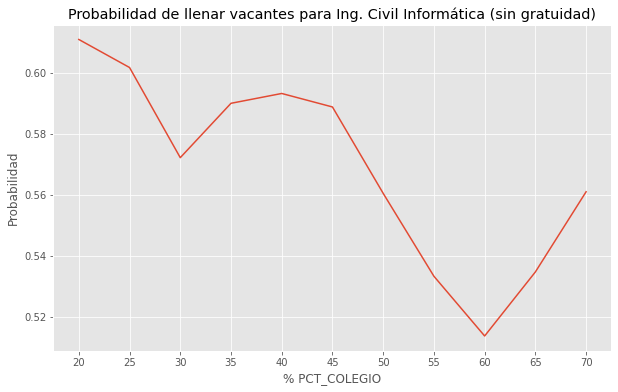

In [ ]:
plt.style.use('ggplot')
plt.figure(figsize=(10,6))
plt.plot(np.arange(20, 71, step=5), probabilidad_k)
plt.xticks(np.arange(20, 71, step=5))
plt.xlabel('% PCT_COLEGIO')
plt.ylabel('Probabilidad')
plt.title('Probabilidad de llenar vacantes para Ing. Civil Informática (sin gratuidad)');

**UDLA diurno - en construcción**

In [ ]:
from google.colab import files
carga = files.upload()

Saving Primera estimación de cupos.xlsx to Primera estimación de cupos.xlsx


In [ ]:
udla_diurno = pd.read_excel('Primera estimación de cupos.xlsx')
udla_diurno.head(3) #ejemplo de 3 observaciones

,CARRERA,CAMPUS,CODIGO,Cupos,Campus,Año,AREA CONOCIMIENTO,acreditacion,gratuidad,duracion,PCT_COLEGIO,matricula_2021,RM,V,VIII,ingreso_3,emplea_1
0,AGRONOMIA,PR,UPR153,20,PROVIDENCIA,2021,Agropecuaria,4,0,10,20,170000,1,0,0,1.124670e+06,0.676724
1,ANIMACION DIGITAL,PR,UPR1103,95,PROVIDENCIA,2021,Arte y Arquitectura,4,0,8,20,170000,1,0,0,NaN,NaN
2,ARQUITECTURA,PR,UPR160,35,PROVIDENCIA,2021,Arte y Arquitectura,4,0,11,20,170000,1,0,0,1.071521e+06,0.741593


In [ ]:
udla_imputer = imputer.transform(udla_diurno[numeric])
udla_imputer = pd.DataFrame(udla_imputer, columns=numeric)

udla_diurno['ingreso_3'] = udla_imputer['ingreso_3']
udla_diurno['emplea_1'] = udla_imputer['emplea_1']

#udla_diurno[features] = udla_diurno
#udla_diurno.isnull().sum()

In [ ]:
probabilidad_k = []
indice = []
ponderacion = []

for i in udla_diurno.index:
  for k in np.arange(20,71, step=5):
    udla_diurno['PCT_COLEGIO'] = k
    X_prueba_k_prep  = preprocessor.transform(udla_diurno.iloc[i:i+1])
    probabilidad_k.append(model.predict_proba(X_prueba_k_prep)[:,1])
    indice.append(i)
    ponderacion.append(k)

salida = pd.DataFrame({'indice':indice, 'ponderacion':ponderacion, 'probabilidad':np.array(probabilidad_k)[:,0]})

In [ ]:
tabla = salida.pivot_table(index=['indice'], columns=['ponderacion'], values='probabilidad', aggfunc='max')
tabla

ponderacion,20,25,30,35,40,45,50,55,60,65,70
indice,,,,,,,,,,,
0,0.412470,0.388244,0.326603,0.349605,0.388721,0.352249,0.332996,0.323370,0.322826,0.306915,0.295981
1,0.495783,0.424644,0.332995,0.338842,0.306699,0.259014,0.236340,0.208801,0.176153,0.165144,0.145132
2,0.603531,0.569079,0.526135,0.530535,0.540589,0.503190,0.470855,0.473430,0.509561,0.489978,0.475566
3,0.133153,0.106691,0.084936,0.088609,0.086677,0.079129,0.069610,0.068438,0.078001,0.078183,0.076046
4,0.523318,0.481788,0.438443,0.436957,0.425127,0.412691,0.396740,0.409689,0.484010,0.504997,0.509427
...,...,...,...,...,...,...,...,...,...,...,...
63,0.591495,0.588557,0.597926,0.629157,0.651608,0.637734,0.606367,0.595548,0.595751,0.592494,0.573089
64,0.058803,0.067052,0.059757,0.063738,0.067783,0.057172,0.049745,0.049727,0.060119,0.057429,0.049759
65,0.807243,0.787250,0.761132,0.780992,0.801403,0.781487,0.758030,0.752531,0.767311,0.768566,0.751729


In [ ]:
salida_2 = pd.concat([udla_diurno, tabla], axis=1).drop(columns='PCT_COLEGIO')
salida_2['pond_max'] = salida_2.loc[:,[20, 25,30,35,40,45,50,55,60,65,70]].idxmax(axis=1)
salida_2['prob_max'] = salida_2.loc[:,[20, 25,30,35,40,45,50,55,60,65,70]].max(axis=1)

salida_2.head()

,CARRERA,CAMPUS,CODIGO,Cupos,Campus,Año,AREA CONOCIMIENTO,acreditacion,gratuidad,duracion,matricula_2021,RM,V,VIII,ingreso_3,emplea_1,20,25,30,35,40,45,50,55,60,65,70,pond_max,prob_max
0,AGRONOMIA,PR,UPR153,20,PROVIDENCIA,2021,Agropecuaria,4,0,10,170000,1,0,0,1.124670e+06,0.676724,0.412470,0.388244,0.326603,0.349605,0.388721,0.352249,0.332996,0.323370,0.322826,0.306915,0.295981,20,0.412470
1,ANIMACION DIGITAL,PR,UPR1103,95,PROVIDENCIA,2021,Arte y Arquitectura,4,0,8,170000,1,0,0,1.112879e+06,0.730970,0.495783,0.424644,0.332995,0.338842,0.306699,0.259014,0.236340,0.208801,0.176153,0.165144,0.145132,20,0.495783
2,ARQUITECTURA,PR,UPR160,35,PROVIDENCIA,2021,Arte y Arquitectura,4,0,11,170000,1,0,0,1.071521e+06,0.741593,0.603531,0.569079,0.526135,0.530535,0.540589,0.503190,0.470855,0.473430,0.509561,0.489978,0.475566,20,0.603531
3,CONSTRUCCION CIVIL,PR,UPR161,15,PROVIDENCIA,2021,Tecnología,4,0,9,170000,1,0,0,1.353673e+06,0.860196,0.133153,0.106691,0.084936,0.088609,0.086677,0.079129,0.069610,0.068438,0.078001,0.078183,0.076046,20,0.133153
4,DERECHO,PR,UPR156,50,PROVIDENCIA,2021,Derecho,4,0,10,170000,1,0,0,1.478155e+06,0.754431,0.523318,0.481788,0.438443,0.436957,0.425127,0.412691,0.396740,0.409689,0.484010,0.504997,0.509427,20,0.523318


In [ ]:
salida_2.to_excel('llenar_vacantes_v2.xlsx')